# Отток клиентов

**Задача:** Обучить модель предсказывать на исторических данных, уйдёт ли клиент из банка. 

Метрика F1-мера.

**План проекта:**

1. Обзор данных
2. Предобработка данных
3. Исследование задачи
    - выборки
    - масштабирование
    - обучение моделей
4. Устранение дисбаланса
    - увеличение выборки
    - уменьшение выборки
5. Тестирование модели 

## Подготовка данных

### Общая информация

In [1]:
# импортируем необходимые библиотеки
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [2]:
# откроем и посмотрим файл
try:
    df = pd.read_csv('/datasets/Churn.csv')
except:
    df = pd.read_csv('/datasets/Churn.csv')

df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


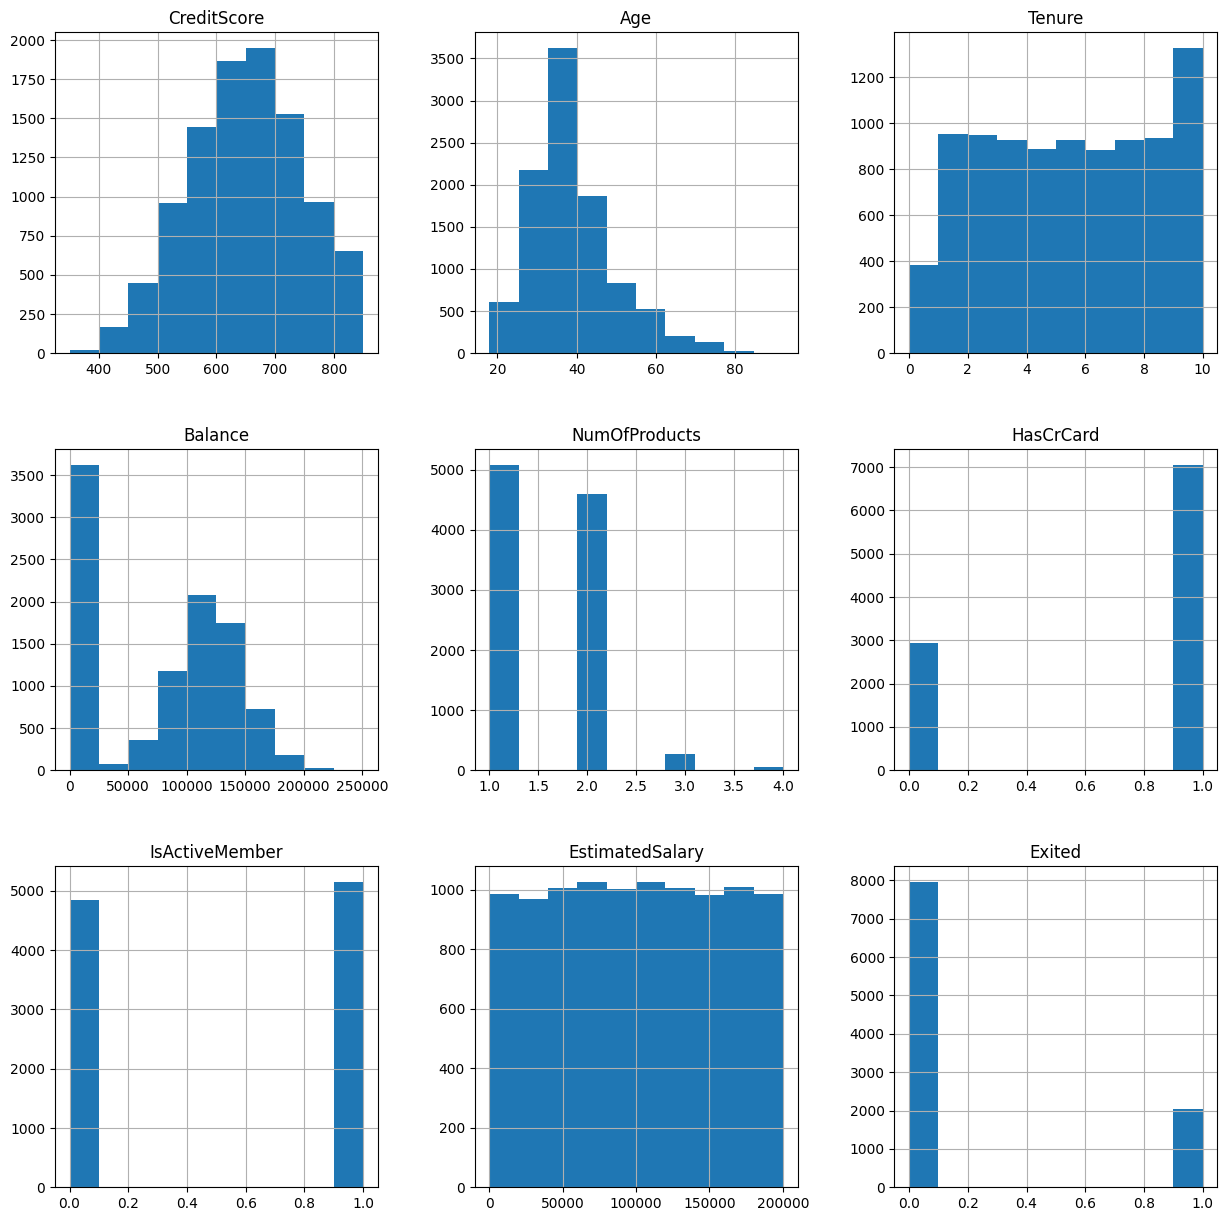

In [5]:
df.drop(['RowNumber', 'CustomerId'], axis=1).hist(figsize=(15, 15));

**Вывод:** Есть пропуски в столбце "Tenure", предположительно пропуски подразуемвают, что клиент только открыл счет в банке. Большое число нулей в "Balance", скорее всего у многих просто заведена дебетовая карта этого банка, но на счету они не держат средств, что вполне нормально. Ошибок в типизации не обнаружено, явных аномалий нет. Заметно, что большое количество отказов от услуг банка.

### Предобработка данных

- Посмотрим ближе на пропуски в Tenure.
- Удалим столбец RowNumber - он просто дублирует индексы строк.
- CastomerId - нужно проверить наличие дубликатов. После этого столбец для дальнейшего прогназирования не понадобиться, удалим его.
- Surname также не несет в себе нужной нам информации, его можно удалить
- Geography и Gender - категориальные данные. Нужно преобразовать их в числа.

In [6]:
# приведем названия стобцов к общему виду
df.columns = df.columns.str.lower()

# приведем к нижнему регистру столбцы с категориальными данными
df['surname'] = df['surname'].str.lower()
df['geography'] = df['geography'].str.lower()
df['gender'] = df['gender'].str.lower()

In [7]:
# посмотрим пропуски
df['tenure'].value_counts()
df['tenure'].isna().sum()

909

In [8]:
df['tenure'].describe()

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: tenure, dtype: float64

Пропусков не много, но с ними нужно что-то сделать.

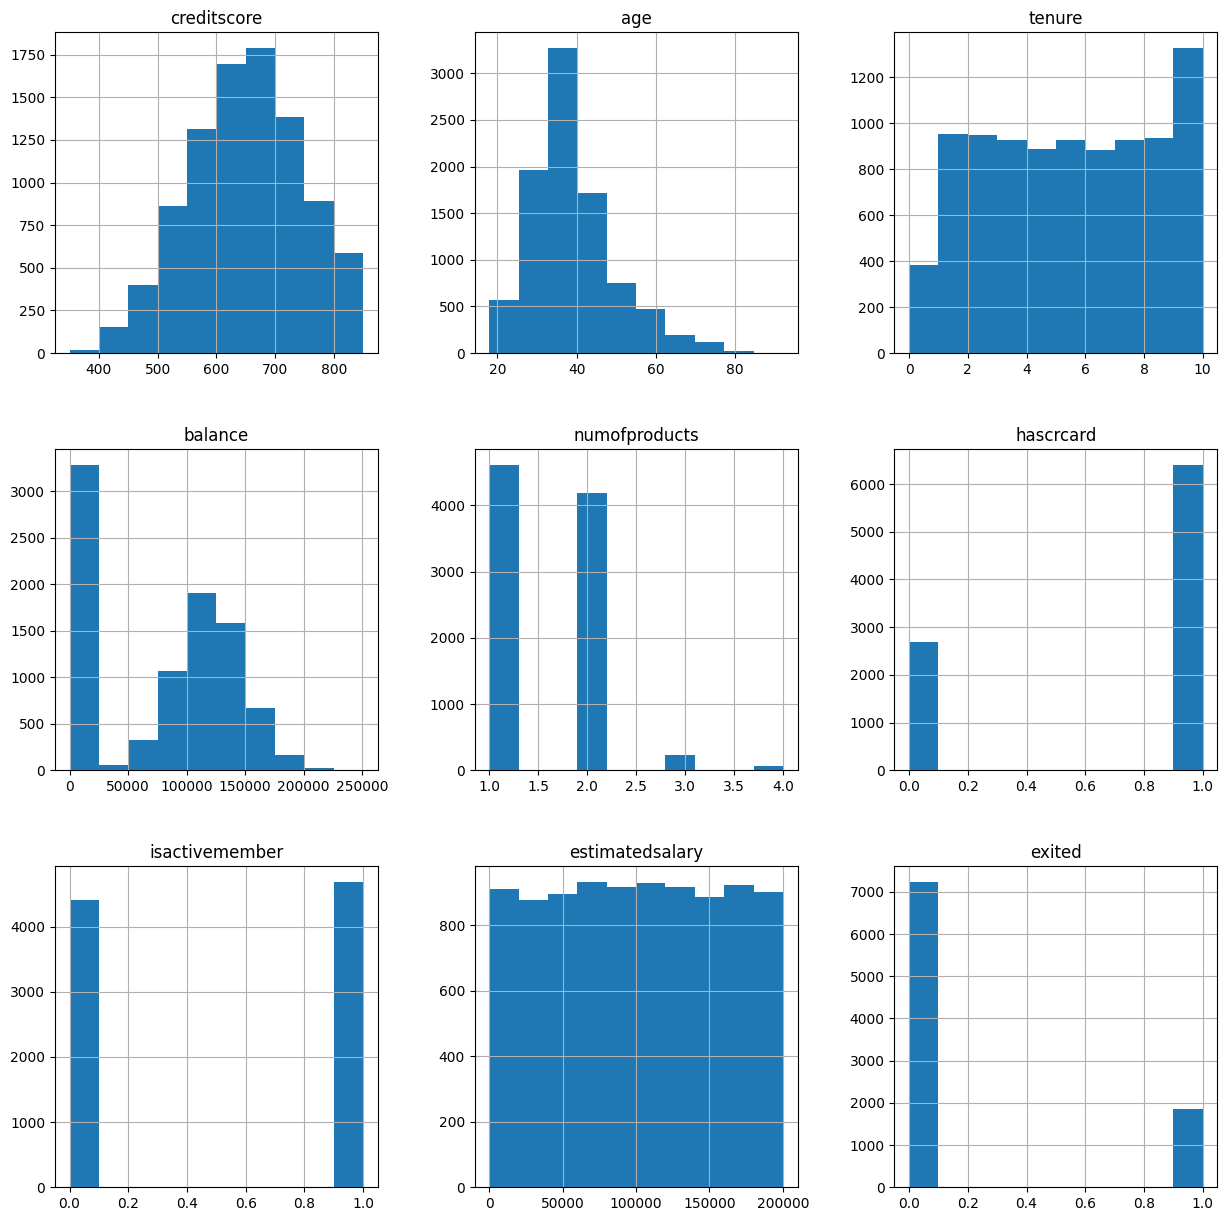

In [9]:
df.drop(['rownumber', 'customerid'], axis=1).loc[~(df['tenure'].isna())].hist(figsize=(15, 15));

Пропуски в Tenure никак не отражаются на других данных. Удалим их.

In [10]:
df = df.loc[~(df['tenure'].isna())]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rownumber        9091 non-null   int64  
 1   customerid       9091 non-null   int64  
 2   surname          9091 non-null   object 
 3   creditscore      9091 non-null   int64  
 4   geography        9091 non-null   object 
 5   gender           9091 non-null   object 
 6   age              9091 non-null   int64  
 7   tenure           9091 non-null   float64
 8   balance          9091 non-null   float64
 9   numofproducts    9091 non-null   int64  
 10  hascrcard        9091 non-null   int64  
 11  isactivemember   9091 non-null   int64  
 12  estimatedsalary  9091 non-null   float64
 13  exited           9091 non-null   int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.0+ MB


In [11]:
# проверим наличие дубликатов
df.duplicated().sum()
df['customerid'].duplicated().sum()

0

Дубликатов не обнаружено. Удалим не нужные столбцы

In [12]:
df.drop(["rownumber", "customerid", "surname"], axis=1, inplace=True)
df.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,france,female,42,2.0,0.00,1,1,1,101348.88,1
1,608,spain,female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,france,female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,france,female,39,1.0,0.00,2,0,0,93826.63,0
4,850,spain,female,43,2.0,125510.82,1,1,1,79084.10,0


Проверим уникальные значение в Geography. Затем методом прямого кодирования преобразуем категориальные данные в количественные в столбцах Geograthy и Gender

In [13]:
df['geography'].unique()

array(['france', 'spain', 'germany'], dtype=object)

In [14]:
df = pd.get_dummies(df, columns=['geography', 'gender'], drop_first=True)
df.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_germany,geography_spain,gender_male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


## Исследование задачи

### Формируем выборки

Создадим перемнные для признаков и целевого признака. Затем поделим выборки на три части в соотношении 3:1:1 на тренировочную, валидационную и тестовую соответственно.

In [15]:
#разделим на признаки и целевой признак
features = df.drop('exited', axis=1)
target = df['exited']

In [16]:
# разделение выборки на тренировочную и валидационную
features_train, features_validtest, target_train, target_validtest = train_test_split(
    features, target, test_size=0.6, random_state=12345, stratify=target)

# выделим из валидационной выборки тестовую
features_valid, features_test, target_valid, target_test = train_test_split(
    features_validtest, target_validtest, test_size=0.5, random_state=12345, 
    stratify=target_validtest)

print('Размер обучающей выборки:', target_train.shape)
print('Размер валидационной выборки:', target_valid.shape)
print('Размер тестовой выборки:', target_test.shape)

Размер обучающей выборки: (3636,)
Размер валидационной выборки: (2727,)
Размер тестовой выборки: (2728,)


### Маштабирование

Привидем признаки к одному масштабу с помощью стандартизации данных

In [17]:
pd.options.mode.chained_assignment = None

# численные признаки
numeric = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary']

# создадим объект структуры StandardScaler и настроим его на обучающих данных
scaler = StandardScaler()
scaler.fit(features_train[numeric])

# преобразуем выборки
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

features_train.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_germany,geography_spain,gender_male
7857,2.099886,-1.124214,0.320745,0.323171,0.787541,0,0,0.935627,0,0,1
44,0.115321,2.101498,-0.026347,1.271365,-0.906837,1,1,1.033026,0,1,0
6468,1.232945,-0.365223,0.320745,0.625846,-0.906837,0,1,-1.235971,0,0,0
3430,-0.250257,-0.175475,-1.414715,1.609494,0.787541,1,1,-0.050007,0,0,1
6441,-1.409661,0.583516,-1.414715,1.637624,-0.906837,1,0,-0.671353,0,0,1


### Обучение моделей

Исследуем балас классов и попробуем обучить модель. Проанализируем адекватность модели и посмотрим на соотношение классов.

0    0.796062
1    0.203938
Name: exited, dtype: float64


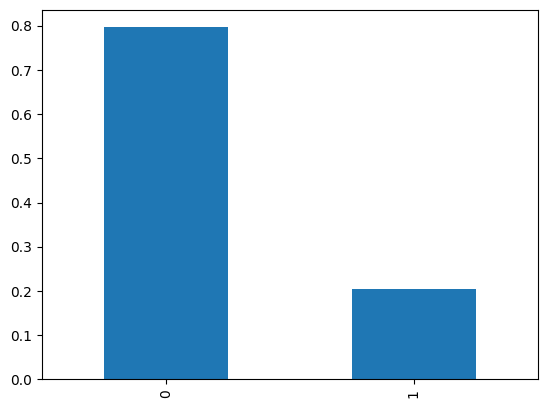

In [18]:
# проверим адекватность модели
class_frequency = df['exited'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar');

In [19]:
# решающее дерево
best_model = None
best_result = 0
best_depth = 0
results = []
for depth in range(1, 16):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train) 
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    results.append({'f1': result, 'depth':depth})
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth
        
print('F1-мера лучшей модели:', best_result)
print('Глубина для лучшей модели:', best_depth)

model_tree_best = DecisionTreeClassifier(random_state=12345, max_depth=7)
model_tree_best.fit(features_train, target_train) 
probabilities_valid = model_tree_best.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("AUC-ROC:", roc_auc_score(target_valid, probabilities_one_valid))

F1-мера лучшей модели: 0.5567226890756302
Глубина для лучшей модели: 7
AUC-ROC: 0.8163350940620143


In [20]:
# случайный лес
best_result = 0
best_model = None
best_est = 0
best_depth = 0
results = []
for est in range(10, 101, 10):
    for depth in range (1, 21):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) 
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid)
        results.append({'f1': result, 'depth':depth, 'est':est})
        if result > best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth

print('F1-мера лучшей модели:', best_result)
print('Глубина для лучшей модели:', best_depth)
print('Количество деревьев:', best_est)

model_forest_best = RandomForestClassifier(random_state=12345, n_estimators=40, max_depth=16)
model_forest_best.fit(features_train, target_train) 
probabilities_valid = model_tree_best.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("AUC-ROC:", roc_auc_score(target_valid, probabilities_one_valid))

F1-мера лучшей модели: 0.5662921348314606
Глубина для лучшей модели: 16
Количество деревьев: 40
AUC-ROC: 0.8163350940620143


In [21]:
# логистическая регрессия
model_reg = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model_reg.fit(features_train, target_train)
predicted_valid = model_reg.predict(features_valid)
probabilities_valid = model_reg.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("F1-мера:", f1_score(target_valid, predicted_valid))
print("AUC-ROC:", roc_auc_score(target_valid, probabilities_one_valid))

F1-мера: 0.29499323410013534
AUC-ROC: 0.7524356378554458


**Вывод:** В данных наблюдается сильный дисбаланс классов - 80% положительных классов к 20% отрицательным, что плохо сказывается на обучении модели. Показатели F1-меры всех обученных моделей ниже, чем требуется. 

## Борьба с дисбалансом

### Увеличение выборки

In [22]:
def upsample(features, target, repeat):
    # разделим тренировочную выборку на положительные и отрицательные объекты
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    # продублируем объекты положительного класса и объединим их с отрицательными
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    # перемешаем данные
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

1    0.506312
0    0.493688
Name: exited, dtype: float64


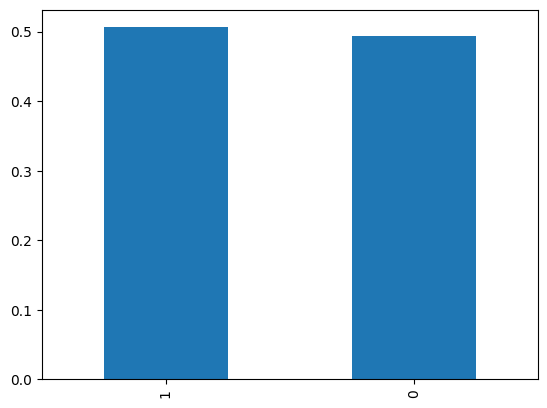

In [23]:
# проверим адекватность модели 
class_frequency = target_upsampled.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar');

In [24]:
# решающее дерево
best_model = None
best_result = 0
best_depth = 0
results = []
for depth in range(1, 16):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_upsampled, target_upsampled) 
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    results.append({'f1': result, 'depth':depth})
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth
        
print('F1-мера лучшей модели:', best_result)
print('Глубина для лучшей модели:', best_depth)

model_tree_best = DecisionTreeClassifier(random_state=12345, max_depth=7)
model_tree_best.fit(features_train, target_train) 
probabilities_valid = model_tree_best.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("AUC-ROC:", roc_auc_score(target_valid, probabilities_one_valid))

F1-мера лучшей модели: 0.5774351786965662
Глубина для лучшей модели: 7
AUC-ROC: 0.8163350940620143


In [25]:
# случайный лес
best_result = 0
best_model = None
best_est = 0
best_depth = 0
results = []
for est in range(10, 101, 10):
    for depth in range (1, 21):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) 
        model.fit(features_upsampled, target_upsampled)
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid)
        results.append({'f1': result, 'depth':depth, 'est':est})
        if result > best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth

print('F1-мера лучшей модели:', best_result)
print('Глубина для лучшей модели:', best_depth)
print('Количество деревьев:', best_est)

model_forest_best = RandomForestClassifier(random_state=12345, n_estimators=70, max_depth=10)
model_forest_best.fit(features_train, target_train) 
probabilities_valid = model_tree_best.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("AUC-ROC:", roc_auc_score(target_valid, probabilities_one_valid))

F1-мера лучшей модели: 0.6196943972835315
Глубина для лучшей модели: 10
Количество деревьев: 70
AUC-ROC: 0.8163350940620143


In [26]:
# логистическая регрессия
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("F1-мера:", f1_score(target_valid, predicted_valid))
print("AUC-ROC:", roc_auc_score(target_valid, probabilities_one_valid))

F1-мера: 0.4821428571428571
AUC-ROC: 0.756202592048885


### Уменьшение выборки

In [27]:
# downsampling

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

1    0.506139
0    0.493861
Name: exited, dtype: float64


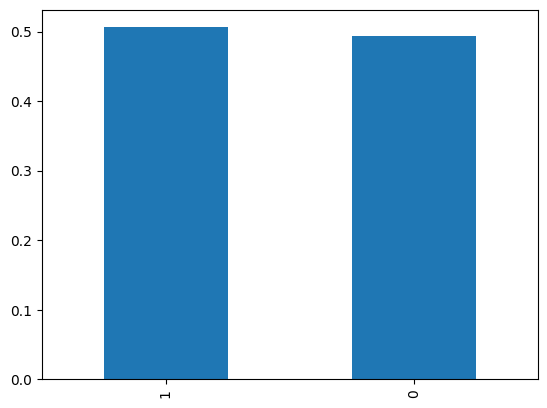

In [28]:
# проверим адекватность модели
class_frequency = target_downsampled.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar');

In [29]:
# решающее дерево
best_model = None
best_result = 0
best_depth = 0
results = []
for depth in range(1, 16):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_downsampled, target_downsampled) 
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    results.append({'f1': result, 'depth':depth})
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth
        
print('F1-мера лучшей модели:', best_result)
print('Глубина для лучшей модели:', best_depth)

model_tree_best = DecisionTreeClassifier(random_state=12345, max_depth=3)
model_tree_best.fit(features_train, target_train) 
probabilities_valid = model_tree_best.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("AUC-ROC:", roc_auc_score(target_valid, probabilities_one_valid))

F1-мера лучшей модели: 0.5655664585191794
Глубина для лучшей модели: 3
AUC-ROC: 0.7910951754487704


In [30]:
# случайный лес
best_result = 0
best_model = None
best_est = 0
best_depth = 0
results = []
for est in range(10, 101, 10):
    for depth in range (1, 21):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) 
        model.fit(features_downsampled, target_downsampled)
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid)
        results.append({'f1': result, 'depth':depth, 'est':est})
        if result > best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth

print('F1-мера лучшей модели:', best_result)
print('Глубина для лучшей модели:', best_depth)
print('Количество деревьев:', best_est)

model_forest_best = RandomForestClassifier(random_state=12345, n_estimators=90, max_depth=14)
model_forest_best.fit(features_train, target_train) 
probabilities_valid = model_tree_best.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("AUC-ROC:", roc_auc_score(target_valid, probabilities_one_valid))

F1-мера лучшей модели: 0.59568345323741
Глубина для лучшей модели: 14
Количество деревьев: 90
AUC-ROC: 0.7910951754487704


In [31]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("F1-мера:", f1_score(target_valid, predicted_valid))
print("AUC-ROC:", roc_auc_score(target_valid, probabilities_one_valid))

F1-мера: 0.4797947402180885
AUC-ROC: 0.7562489851508937


**Вывод:** Показатели выше при upsampling в модели случайного леса. Лучшая модель при глубине 10 и количеством деревьев 70, F1-мера равна 0,62.

## Тестирование модели

In [32]:
model = RandomForestClassifier(random_state=12345, n_estimators=40, max_depth=12) 
model.fit(features_upsampled, target_upsampled)
predicted = model.predict(features_test)
result = f1_score(target_test, predicted)
print('F1 на лучшей модели:', result)

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

print("AUC-ROC:", roc_auc_score(target_test, probabilities_one_test))

F1 на лучшей модели: 0.6247723132969035
AUC-ROC: 0.8527962160658213


## Общий вывод

* В ходе исследования была выполнена предобработка данных, устранены пропуски и использован метод прямого кодирования.
* Проанализированы данные на предмент дисбаланса - есть сильный дисбаланс в сторону отрицательных классов.
* Исследованы модели решающего дерева, случайного леса и логистической регрессии на несбалансированных.
* Были применены методы увеличения и уменьшения классов для устранения дисбаланса. Эффективней себе показал upsampling.
* Изучены модели обученные на сбалансированных данных.
* Найдена лучшая модель - модель случайного леса с глубиной 10 и количеством деревьев 70. F1-мера равна 0.62, что было подтверждено на тестовой выборке. 